In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import scipy.stats as stats



In [4]:
# read in each year and change the name of the Data_Value column to the name of the year and what it represents
data_frames = []
for num in range(2013, 2019):
    df = pd.read_csv(f'../data/heart_dis_{num}.csv')
    df[f'{num}_mort_per_100k'] = df['Data_Value']
    if num != 2013:
        data_frames.append(df[[f'{num}_mort_per_100k', 
                               'LocationID', 'Stratification1', 'Stratification2', 'GeographicLevel']])
    else:
        data_frames.append(df)

In [5]:
# Remove data 
cleaned = []
for df in data_frames:
    temp = df[(df['Stratification1'] == 'Overall') 
              & (df['Stratification2'] == 'Overall') 
              & (df['GeographicLevel'] == 'County')]
    temp = temp.drop(columns=['Stratification1', 'Stratification2', 'GeographicLevel'])
    cleaned.append(temp)
    


In [6]:
# Merging all years on the key of 'LocationDesc'
data_set = pd.merge(cleaned[0], cleaned[1], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[2], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[3], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[4], on='LocationID', how='inner')
data_set = pd.merge(data_set, cleaned[5], on='LocationID', how='inner')

data_set.shape


(3219, 22)

In [7]:
data_set = data_set.dropna(subset=['2013_mort_per_100k', '2014_mort_per_100k', 
                        '2015_mort_per_100k', '2016_mort_per_100k',
                       '2017_mort_per_100k', '2018_mort_per_100k'])
data_set.columns

Index(['Year', 'LocationAbbr', 'LocationDesc', 'DataSource', 'Class', 'Topic',
       'Data_Value', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'StratificationCategory1', 'StratificationCategory2', 'TopicID',
       'LocationID', 'Location', '2013_mort_per_100k', '2014_mort_per_100k',
       '2015_mort_per_100k', '2016_mort_per_100k', '2017_mort_per_100k',
       '2018_mort_per_100k'],
      dtype='object')

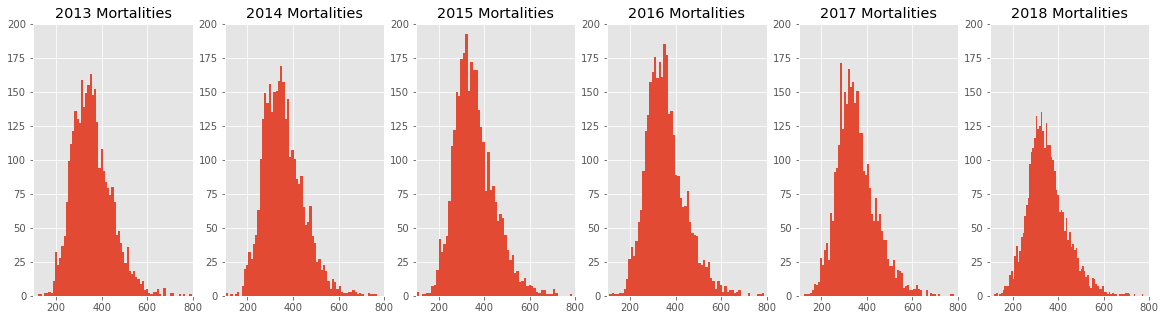

In [8]:
fig, axs = plt.subplots(1,6, figsize=(20,5))
for i in range(6):
    axs[i].hist(data_set[f'{2013+i}_mort_per_100k'], bins=100)
    axs[i].set_xlim(100,800)
    axs[i].set_ylim(0,200)
    axs[i].set_title(f'{2013+i} Mortalities');

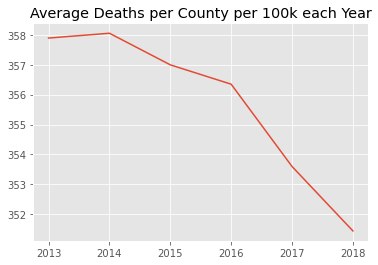

In [9]:
y = []
for i in range(6):
    y.append(data_set[f'{2013+i}_mort_per_100k'].mean())
x = [2013, 2014, 2015, 2016, 2017, 2018]
fig, ax = plt.subplots()
ax.plot(x,y)
ax.set_title('Average Deaths per County per 100k each Year');


In [11]:
#Load in tempurature data and strip the word county from location column
temps = []
for i in range(2013, 2019):
    temperature = pd.read_csv(f'../data/temperature/{i}_temp.csv', sep=",", engine='python')
    temperature['LocationDesc'] = temperature['Location'].str.rstrip('County')
    temperature['LocationDesc'] = temperature['LocationDesc'].str.rstrip(' ')
    temperature['LocationAbbr'] = temperature['Location ID'].str[:2]
    temperature = temperature.rename(columns={"Value": f'{i}_average_temp'})
    temperature = temperature.drop(['Rank', 'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'Location'], axis=1)                            
    temps.append(temperature)


In [12]:
data_set['LocationDesc'] = data_set['LocationDesc'].str.rstrip('County')
data_set['LocationDesc'] = data_set['LocationDesc'].str.rstrip(' ')
for df in temps:
     data_set = pd.merge(data_set, df, on=['LocationDesc', 'LocationAbbr'], how='inner')
   

data_set

,Year,LocationAbbr,LocationDesc,DataSource,Class,Topic,Data_Value,Data_Value_Unit,Data_Value_Type,Data_Value_Footnote_Symbol,...,Location ID_y,2014_average_temp,Location ID_x,2015_average_temp,Location ID_y,2016_average_temp,Location ID_x,2017_average_temp,Location ID_y,2018_average_temp
0,2013,AL,Blount,NVSS,Cardiovascular Diseases,Heart Disease Mortality,385.8,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-009,59.3,AL-009,60.5,AL-009,62.4,AL-009,64.6,AL-009,62.0
1,2013,AL,Autauga,NVSS,Cardiovascular Diseases,Heart Disease Mortality,445.2,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-001,62.4,AL-001,63.5,AL-001,65.7,AL-001,66.9,AL-001,64.7
2,2013,AL,Baldwin,NVSS,Cardiovascular Diseases,Heart Disease Mortality,376.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-003,65.7,AL-003,66.2,AL-003,68.6,AL-003,69.7,AL-003,67.9
3,2013,AL,Barbour,NVSS,Cardiovascular Diseases,Heart Disease Mortality,476.7,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-005,63.4,AL-005,64.3,AL-005,66.4,AL-005,67.7,AL-005,66.0
4,2013,AL,Bibb,NVSS,Cardiovascular Diseases,Heart Disease Mortality,458.9,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,AL-007,61.1,AL-007,62.1,AL-007,63.9,AL-007,65.4,AL-007,63.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3099,2013,WY,Niobrara,NVSS,Cardiovascular Diseases,Heart Disease Mortality,312.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,WY-027,45.6,WY-027,44.9,WY-027,47.5,WY-027,47.4,WY-027,47.3
3100,2013,WY,Park,NVSS,Cardiovascular Diseases,Heart Disease Mortality,273.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,WY-029,39.1,WY-029,39.2,WY-029,41.2,WY-029,40.5,WY-029,40.8
3101,2013,WY,Platte,NVSS,Cardiovascular Diseases,Heart Disease Mortality,309.9,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,WY-031,46.4,WY-031,46.4,WY-031,48.5,WY-031,48.2,WY-031,48.5
3102,2013,WY,Sheridan,NVSS,Cardiovascular Diseases,Heart Disease Mortality,350.9,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,WY-033,43.0,WY-033,42.6,WY-033,45.4,WY-033,44.7,WY-033,44.4


In [13]:
# Normalized data so it could be compared
data_set['2013_norm_deaths'] = (data_set['2013_mort_per_100k']-data_set['2013_mort_per_100k'].min())/(data_set['2013_mort_per_100k'].max()-data_set['2013_mort_per_100k'].min())
data_set['2013_norm_temp'] = (data_set['2013_average_temp']-data_set['2013_average_temp'].min())/(data_set['2013_average_temp'].max()-data_set['2013_average_temp'].min())


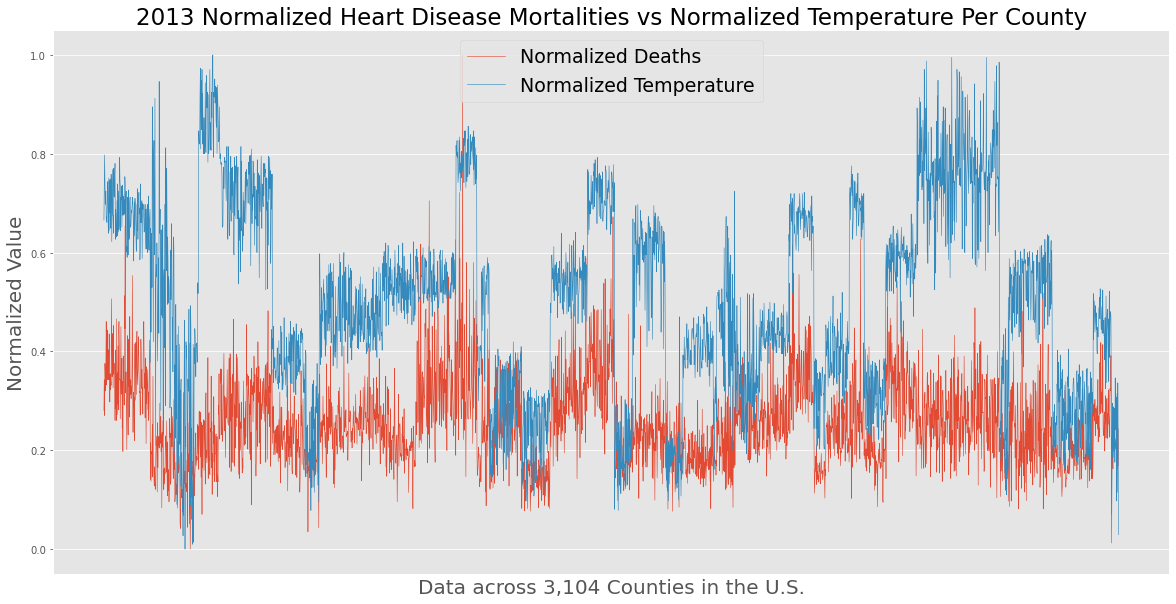

In [106]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_set['2013_norm_deaths'], label='Normalized Deaths', linewidth=.6)
ax.plot(data_set['2013_norm_temp'], label='Normalized Temperature', linewidth=.6)
ax.set_title('2013 Normalized Heart Disease Mortalities vs Normalized Temperature Per County', size=23)
ax.set_xticks([])
ax.set_ylabel('Normalized Value', size=20)
ax.set_xlabel('Data across 3,104 Counties in the U.S.', size=20)
ax.legend(prop={'size': 19})
plt.savefig('../images/normalized_temp_death.jpg', bbox_inches='tight')


In [15]:
states = data_set.groupby('LocationAbbr').mean()
states = states.reset_index()
states.head()

,LocationAbbr,Year,Data_Value,LocationID,2013_mort_per_100k,2014_mort_per_100k,2015_mort_per_100k,2016_mort_per_100k,2017_mort_per_100k,2018_mort_per_100k,2013_average_temp,2014_average_temp,2015_average_temp,2016_average_temp,2017_average_temp,2018_average_temp,2013_norm_deaths,2013_norm_temp
0,AL,2013.0,466.973134,1067.000000,466.973134,473.443284,470.359701,471.467164,465.728358,462.434328,64.716418,61.304478,62.346269,64.371642,65.934328,63.832836,0.365554,0.700400
1,AR,2013.0,448.858667,5075.000000,448.858667,452.524000,455.125333,459.426667,450.712000,446.986667,63.373333,59.040000,58.920000,61.429333,63.230667,61.708000,0.346546,0.667642
2,AZ,2013.0,291.093333,4013.866667,291.093333,287.786667,288.713333,288.273333,288.693333,283.926667,62.953333,62.566667,63.506667,62.866667,63.626667,64.886667,0.181000,0.657398
3,CA,2013.0,304.968966,6058.000000,304.968966,303.001724,297.774138,299.700000,292.243103,287.056897,57.715517,58.805172,60.191379,59.415517,58.663793,59.555172,0.195560,0.529647
4,CO,2013.0,251.106250,8062.234375,251.106250,250.067188,252.764062,250.128125,246.039063,240.192187,46.942188,44.596875,45.501563,46.357813,46.514062,47.565625,0.139041,0.266883


In [129]:
print(data_set['2013_mort_per_100k'].mean())
data_set[data_set['2013_mort_per_100k'] > 800]

361.892912371135


,Year,LocationAbbr,LocationDesc,DataSource,Class,Topic,Data_Value,Data_Value_Unit,Data_Value_Type,Data_Value_Footnote_Symbol,...,2014_hh_mean_income,2014_percentage_less_than_25k,2015_hh_mean_income,2015_percentage_less_than_25k,2016_hh_mean_income,2016_percentage_less_than_25k,2017_hh_mean_income,2017_percentage_less_than_25k,2018_hh_mean_income,2018_percentage_less_than_25k
1087,2013,LA,Caldwell Parish,NVSS,Cardiovascular Diseases,Heart Disease Mortality,806.4,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,54710,1.004934,52534,1.099531,49629,1.270977,53119,1.179348,53766.0,1.120807
1097,2013,LA,Franklin Parish,NVSS,Cardiovascular Diseases,Heart Disease Mortality,1071.6,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,46518,0.553691,45837,0.581068,47209,0.565160,48217,0.539229,50778.0,0.498099


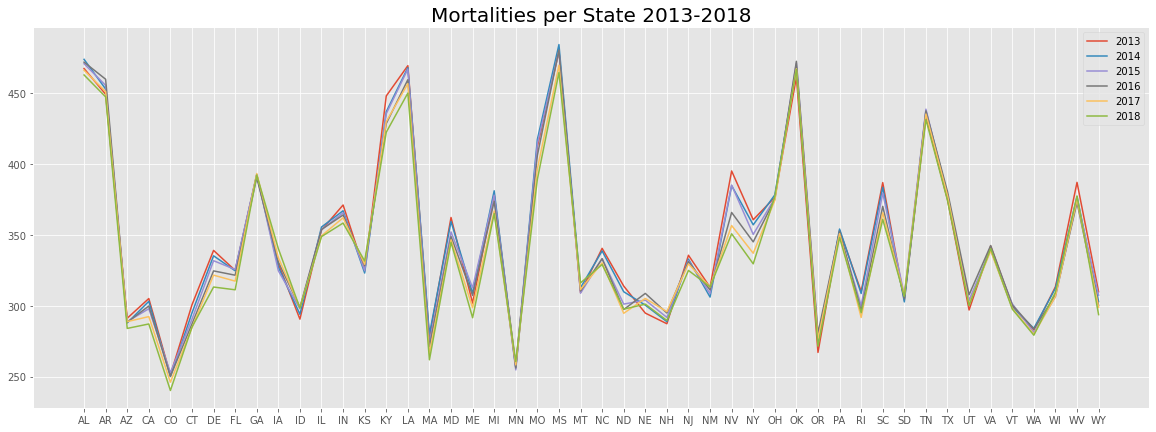

In [16]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(states['LocationAbbr'], states['2013_mort_per_100k'], label='2013')
ax.plot(states['LocationAbbr'], states['2014_mort_per_100k'], label='2014')
ax.plot(states['LocationAbbr'], states['2015_mort_per_100k'], label='2015')
ax.plot(states['LocationAbbr'], states['2016_mort_per_100k'], label='2016')
ax.plot(states['LocationAbbr'], states['2017_mort_per_100k'], label='2017')
ax.plot(states['LocationAbbr'], states['2018_mort_per_100k'], label='2018')
ax.set_title('Mortalities per State 2013-2018', size=20)

ax.legend()
plt.show()

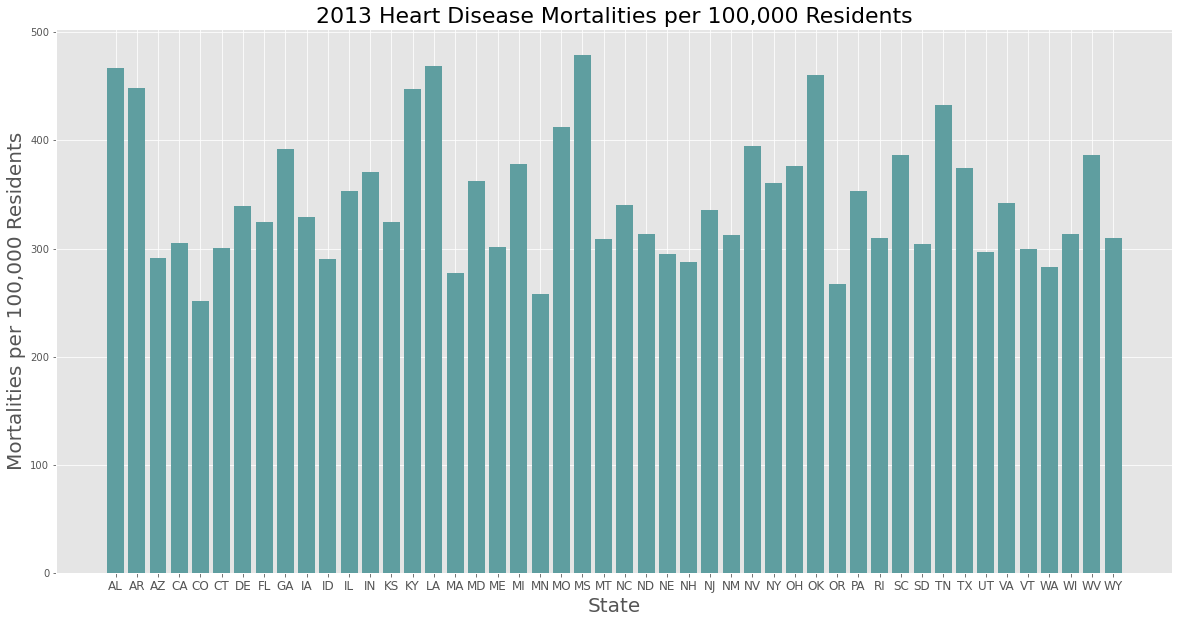

In [60]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(0, 48):
    ax.bar(states.loc[i, 'LocationAbbr'], states.loc[i, '2013_mort_per_100k'], color='cadetblue') 
    
ax.set_title('2013 Heart Disease Mortalities per 100,000 Residents', size=22)
ax.set_xlabel('State', size=20)
ax.set_ylabel('Mortalities per 100,000 Residents', size=20)
ax.tick_params(axis='x', labelsize=12)
plt.savefig('../images/heart_dis_by_state.jpg', bbox_inches = 'tight')

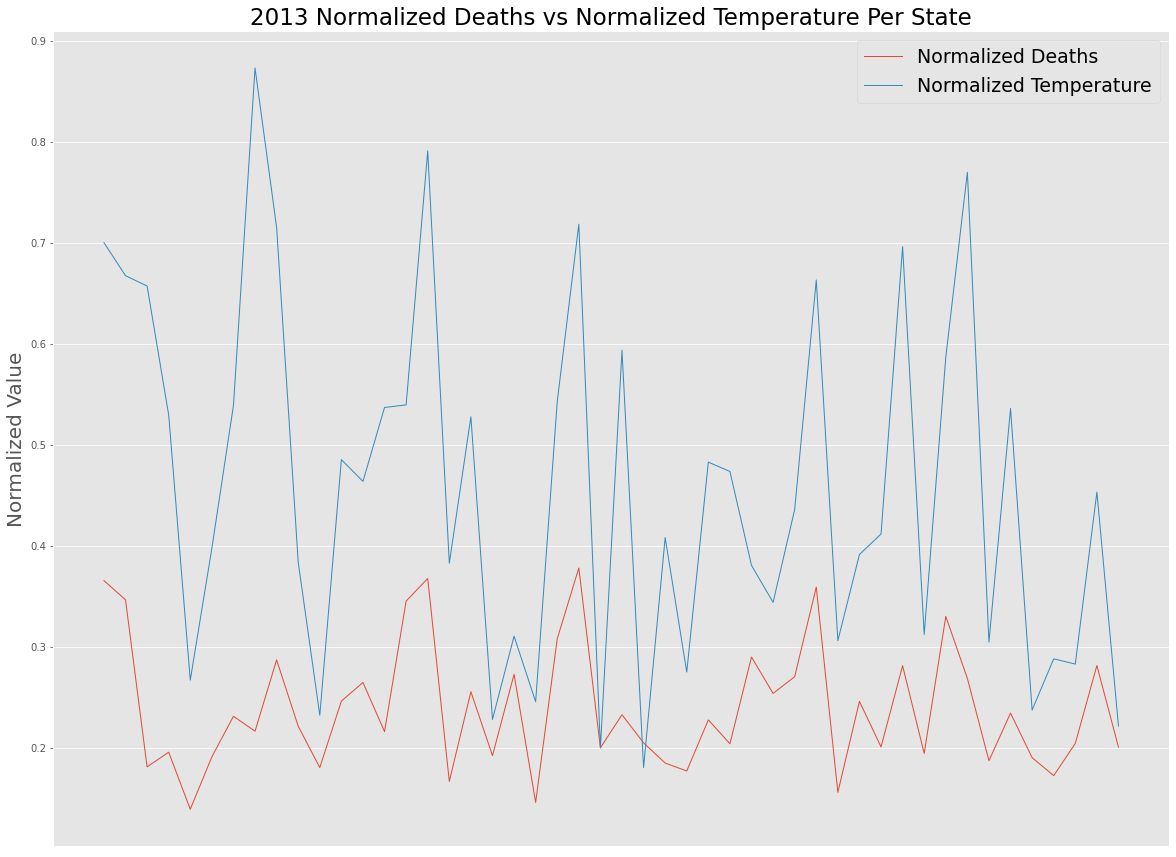

In [18]:
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(states['2013_norm_deaths'], label='Normalized Deaths', linewidth=1)
ax.plot(states['2013_norm_temp'], label='Normalized Temperature', linewidth=1)
ax.set_title('2013 Normalized Deaths vs Normalized Temperature Per State', size=23)
ax.xaxis.set_visible(False)
ax.set_ylabel('Normalized Value', size=20)
ax.legend(prop={'size': 19});


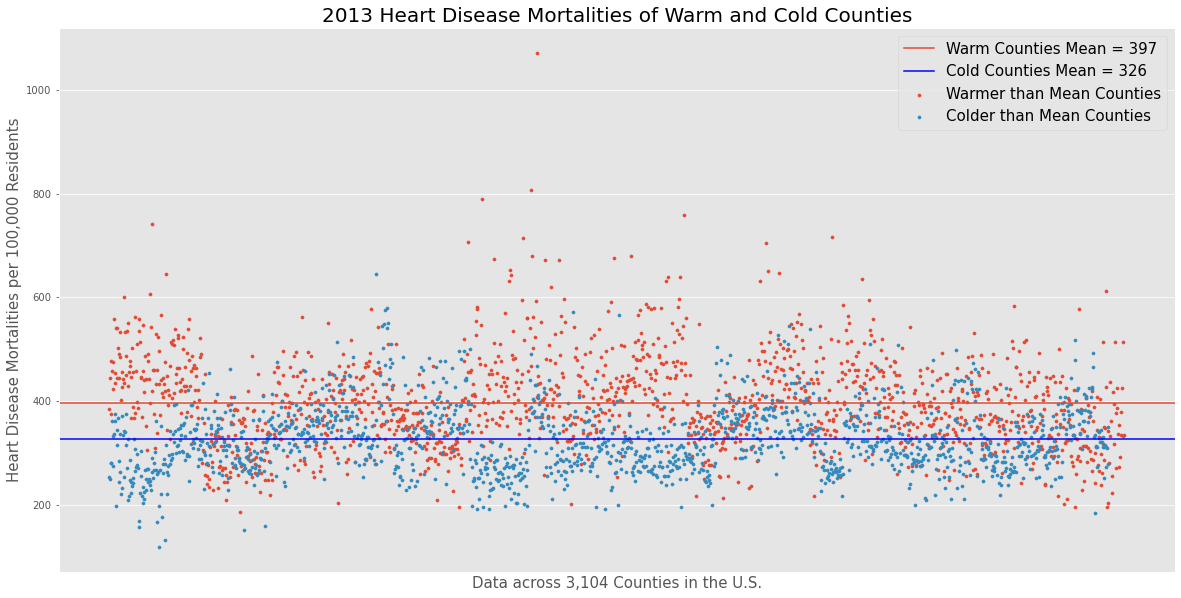

In [86]:
# divide our data into counties where the temperature is above the mean
hot_counties = data_set[data_set['2013_average_temp'] > data_set['2013_average_temp'].mean()] 
cold_counties = data_set[data_set['2013_average_temp'] < data_set['2013_average_temp'].mean()] 
hot_mean = hot_counties['2013_mort_per_100k'].mean()
cold_mean= cold_counties['2013_mort_per_100k'].mean()
fig, ax = plt.subplots(figsize=(20, 10))
x1 = list(range(hot_counties.shape[0]))
ax.scatter(x1, hot_counties['2013_mort_per_100k'], s=10, label='Warmer than Mean Counties')

x2 = list(range(cold_counties.shape[0]))
ax.scatter(x2, cold_counties['2013_mort_per_100k'], s=10, label='Colder than Mean Counties')
ax.axhline(hot_counties['2013_mort_per_100k'].mean(), label=f'Warm Counties Mean = {int(hot_mean)}')
ax.axhline(cold_counties['2013_mort_per_100k'].mean(), c='blue', label=f'Cold Counties Mean = {int(cold_mean)}')
ax.set_title('2013 Heart Disease Mortalities of Warm and Cold Counties', size=20)
ax.legend(prop={'size': 15})
ax.set_xticks([])
ax.set_xlabel('Data across 3,104 Counties in the U.S.', size=15)
ax.set_ylabel('Heart Disease Mortalities per 100,000 Residents', size=15)
plt.savefig('../images/warm_cold_scatter.jpg', bbox_inches='tight')

In [20]:
stats.ttest_ind(hot_counties['2013_mort_per_100k'], cold_counties['2013_mort_per_100k'])

Ttest_indResult(statistic=25.510697455171485, pvalue=1.769354495768219e-130)

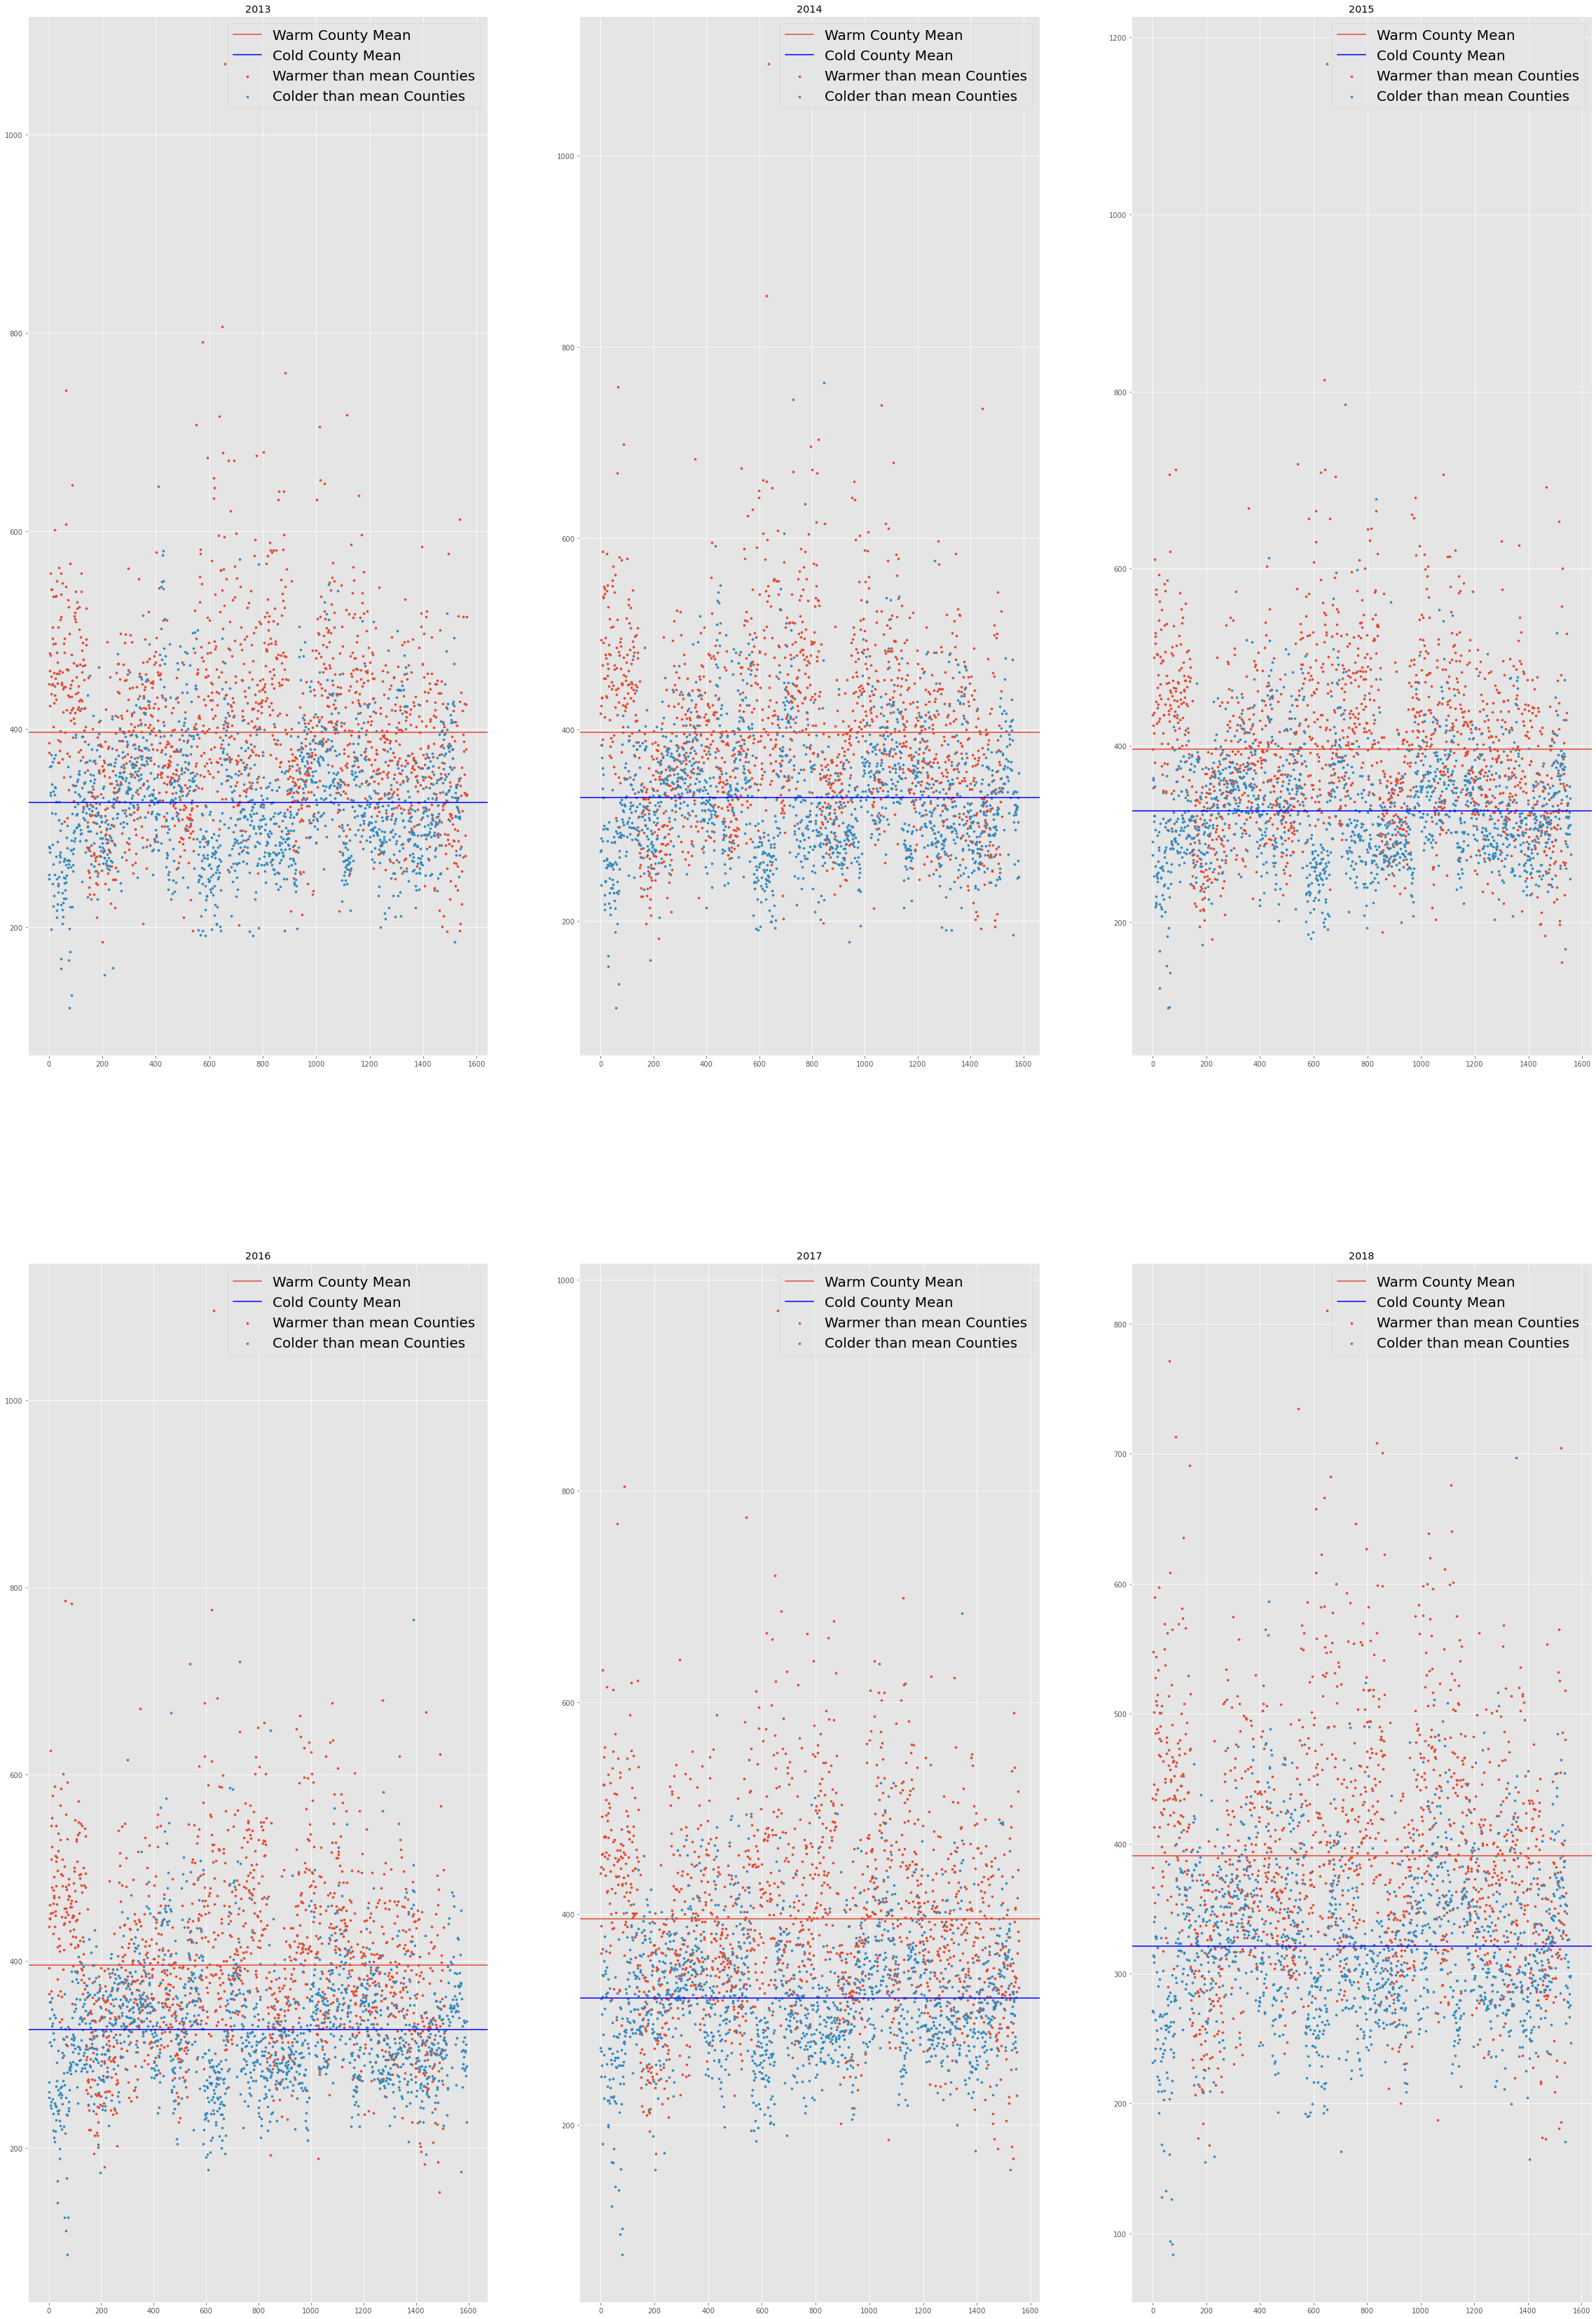

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(40, 60))
count = 0
for i in range(2):
    for j in range(3):
        hot_counties = data_set[data_set[f'{2013+count}_average_temp'] > data_set[f'{2013+count}_average_temp'].mean()] 
        cold_counties = data_set[data_set[f'{2013+count}_average_temp'] < data_set[f'{2013+count}_average_temp'].mean()] 
        x1 = list(range(hot_counties.shape[0]))
        axs[i][j].scatter(x1, hot_counties[f'{2013+count}_mort_per_100k'], s=10, label='Warmer than mean Counties')

        x2 = list(range(cold_counties.shape[0]))
        axs[i][j].scatter(x2, cold_counties[f'{2013+count}_mort_per_100k'], s=10, label='Colder than mean Counties')

        axs[i][j].axhline(hot_counties[f'{2013+count}_mort_per_100k'].mean(), label='Warm County Mean')
        axs[i][j].axhline(cold_counties[f'{2013+count}_mort_per_100k'].mean(), c='blue', label='Cold County Mean')
        axs[i][j].set_title(f'{2013+count}')
        axs[i][j].legend(prop={'size': 20})
        count += 1


In [22]:
income_data = []
for i in range(2013, 2019):
    df = pd.read_csv(f'../data/income/{i}_income.csv', sep=",", engine='python')

    # Cleaning the LocationID column so we can merge with other data set
    df['LocationID'] = df['id'].str[9:]
    df['LocationID'] = df['LocationID'].str.lstrip('0')
    df['LocationID'] = df['LocationID'].astype(str).astype(int)
    df[f'{i}_percentage_less_than_25k'] = ((df.iloc[:, 4] + df.iloc[:, 6] + df.iloc[:, 8]) / df.iloc[:, 2]) * 100
    # Selecting just the columns I want
    df = df.iloc[:,[26, 130, 131]]
    df = df.rename(columns={'Households!!Estimate!!Mean income (dollars)': f'{i}_hh_mean_income',
                           'Estimate!!Households!!Mean income (dollars)': f'{i}_hh_mean_income'})
    income_data.append(df)
    
income_data[0]

,2013_hh_mean_income,LocationID,2013_percentage_less_than_25k
0,64699,1001,0.103632
1,66835,1003,0.032340
2,43926,1005,0.451087
3,48885,1007,0.507686
4,54820,1009,0.125071
...,...,...,...
3216,26009,72145,0.376208
3217,22008,72147,2.362657
3218,24221,72149,0.825770
3219,22984,72151,0.534934


In [23]:
for df in income_data:
    data_set = pd.merge(data_set, df, on='LocationID', how='inner')
data_set

,Year,LocationAbbr,LocationDesc,DataSource,Class,Topic,Data_Value,Data_Value_Unit,Data_Value_Type,Data_Value_Footnote_Symbol,...,2014_hh_mean_income,2014_percentage_less_than_25k,2015_hh_mean_income,2015_percentage_less_than_25k,2016_hh_mean_income,2016_percentage_less_than_25k,2017_hh_mean_income,2017_percentage_less_than_25k,2018_hh_mean_income,2018_percentage_less_than_25k
0,2013,AL,Blount,NVSS,Cardiovascular Diseases,Heart Disease Mortality,385.8,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,54689,0.125155,54884,0.123943,56439,0.121247,58974,0.117931,60646.0,0.123301
1,2013,AL,Autauga,NVSS,Cardiovascular Diseases,Heart Disease Mortality,445.2,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,64414,0.104905,64765,0.106884,67651,0.104327,72110,0.104968,75515.0,0.108927
2,2013,AL,Baldwin,NVSS,Cardiovascular Diseases,Heart Disease Mortality,376.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,67238,0.032577,68169,0.032252,70277,0.031005,73061,0.028765,77212.0,0.025184
3,2013,AL,Barbour,NVSS,Cardiovascular Diseases,Heart Disease Mortality,476.7,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,46592,0.429743,44688,0.436998,45280,0.435212,45445,0.431944,47909.0,0.421293
4,2013,AL,Bibb,NVSS,Cardiovascular Diseases,Heart Disease Mortality,458.9,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,50508,0.447867,52241,0.426925,53863,0.435585,61099,0.394737,58529.0,0.402047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3099,2013,WY,Niobrara,NVSS,Cardiovascular Diseases,Heart Disease Mortality,312.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,59703,3.162562,58528,3.023923,57040,3.180428,55337,3.044807,55646.0,3.231084
3100,2013,WY,Park,NVSS,Cardiovascular Diseases,Heart Disease Mortality,273.1,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,67802,0.134457,69272,0.131957,72810,0.127685,78149,0.131234,83367.0,0.131920
3101,2013,WY,Platte,NVSS,Cardiovascular Diseases,Heart Disease Mortality,309.9,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,55468,0.737127,57106,0.769026,68482,0.741848,71200,0.655080,70433.0,0.564024
3102,2013,WY,Sheridan,NVSS,Cardiovascular Diseases,Heart Disease Mortality,350.9,"per 100,000 population","Age-adjusted, Spatially Smoothed, 3-year Avera...",NaN,...,68432,0.163908,68777,0.166958,67831,0.166969,71834,0.153846,77032.0,0.150467


''

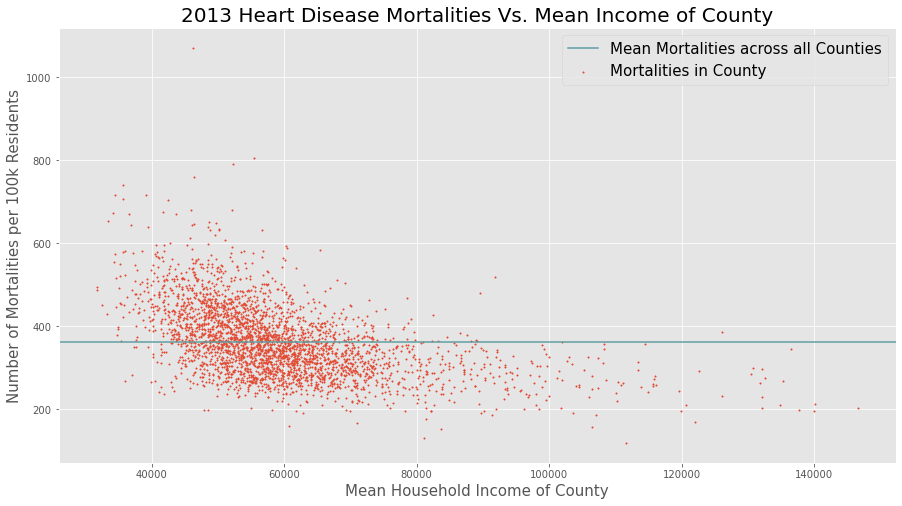

In [111]:
sorted_by_income = data_set.sort_values('2013_hh_mean_income')
fig, ax = plt.subplots(figsize=(15, 8))

ax.scatter(sorted_by_income['2013_hh_mean_income'], sorted_by_income['2013_mort_per_100k'], s=2, 
            label='Mortalities in County')
ax.axhline(sorted_by_income['2013_mort_per_100k'].mean(), label='Mean Mortalities across all Counties', c='cadetblue')
ax.set_xlabel('Mean Household Income of County', size=15)
ax.set_ylabel('Number of Mortalities per 100k Residents', size=15)
ax.set_title('2013 Heart Disease Mortalities Vs. Mean Income of County', size=20)
ax.legend(prop={'size': 15})
plt.savefig('../images/mort_income.jpg', bbox_inches='tight')
;

<BarContainer object of 1 artists>

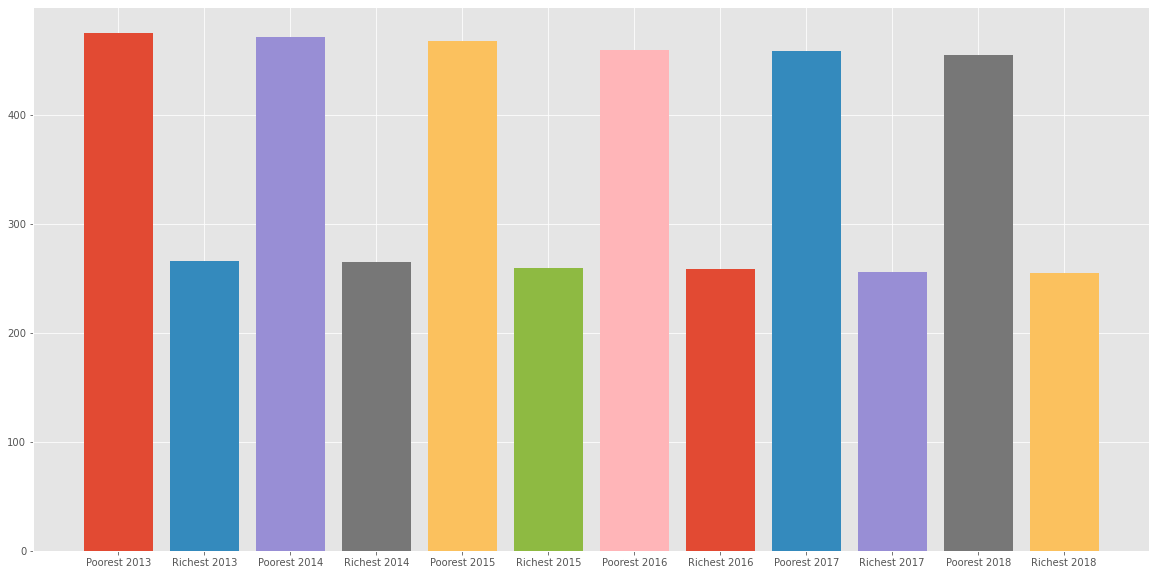

In [25]:
poorest_counties = sorted_by_income.iloc[:100]
richest_counties = sorted_by_income.iloc[-100:]
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar('Poorest 2013', poorest_counties['2013_mort_per_100k'].mean())
ax.bar('Richest 2013', richest_counties['2013_mort_per_100k'].mean())
ax.bar('Poorest 2014', poorest_counties['2014_mort_per_100k'].mean())
ax.bar('Richest 2014', richest_counties['2014_mort_per_100k'].mean())
ax.bar('Poorest 2015', poorest_counties['2015_mort_per_100k'].mean())
ax.bar('Richest 2015', richest_counties['2015_mort_per_100k'].mean())
ax.bar('Poorest 2016', poorest_counties['2016_mort_per_100k'].mean())
ax.bar('Richest 2016', richest_counties['2016_mort_per_100k'].mean())
ax.bar('Poorest 2017', poorest_counties['2017_mort_per_100k'].mean())
ax.bar('Richest 2017', richest_counties['2017_mort_per_100k'].mean())
ax.bar('Poorest 2018', poorest_counties['2018_mort_per_100k'].mean())
ax.bar('Richest 2018', richest_counties['2018_mort_per_100k'].mean())


475.40299999999996
266.177


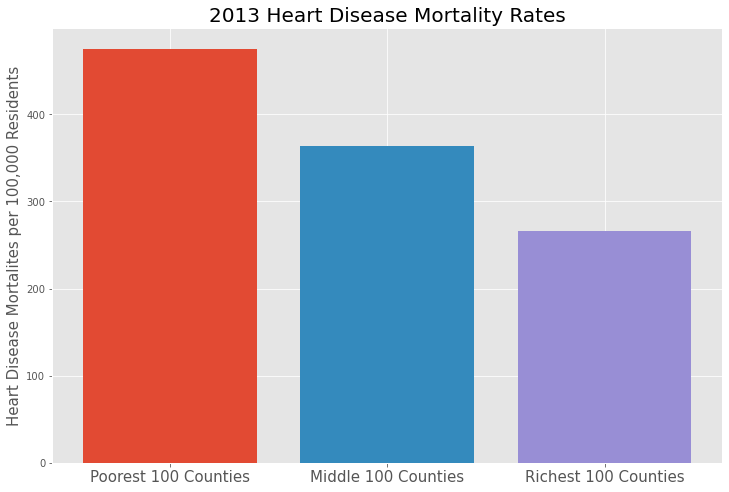

In [126]:
poorest_counties = sorted_by_income.iloc[:100]
middle_counties = sorted_by_income.iloc[1502:1602]
richest_counties = sorted_by_income.iloc[-100:]
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar('Poorest 100 Counties', poorest_counties['2013_mort_per_100k'].mean())
ax.bar('Middle 100 Counties', middle_counties['2013_mort_per_100k'].mean())
ax.bar('Richest 100 Counties', richest_counties['2013_mort_per_100k'].mean())
ax.set_title('2013 Heart Disease Mortality Rates', size=20)
ax.set_ylabel('Heart Disease Mortalites per 100,000 Residents', size=15)
ax.tick_params(axis='x', labelsize=15)
plt.savefig('../images/poor_mid_rich.jpg', bbox_inches='tight')
print(poorest_counties['2013_mort_per_100k'].mean())
print(richest_counties['2013_mort_per_100k'].mean())